#### Import Python Models

In [1]:
import matplotlib.pyplot as plt
# Improve the quality of figures
plt.rcParams['figure.dpi'] = 300
# Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import networkx as nx
# fix the seed 


#### Console

In [2]:
np.random.seed(0)
N_RF = 1000
SNR = 50 # dB

### Hide Part 1

#### Read Generated Channel Data

In [3]:
# read data from \generate_channel_data\generate_channel_data.mat
import scipy.io as sio
generate_channel_data = sio.loadmat('./data/generate_channel_data.mat')
cluster_para = generate_channel_data['meta_data']['cluster_para']
# xi = generate_channel_data['meta_data']['xi']
f_c = generate_channel_data['meta_data']['f_c']
N_x = int(generate_channel_data['meta_data']['N_x'])
N_y = int(generate_channel_data['meta_data']['N_y'])
lambda_c = generate_channel_data['meta_data']['lambda_c']
delta = generate_channel_data['meta_data']['delta']
N = int(generate_channel_data['meta_data']['N'])
L_x = generate_channel_data['meta_data']['L_x']
L_y = generate_channel_data['meta_data']['L_y']

H_channel = np.mat(generate_channel_data['channel']['H_channel'][0][0])
vec_H_a = np.mat(generate_channel_data['channel']['vec_H_a'][0][0])
variance = np.mat(generate_channel_data['channel']['variance'][0][0])
Psi = np.mat(generate_channel_data['channel']['Psi'][0][0])




In [4]:
xi = []
l_x_abs_max = int(L_x / lambda_c)
l_y_abs_max = int(L_y / lambda_c)
print("l_x_abs_max = ", l_x_abs_max)
print("l_y_abs_max = ", l_y_abs_max)

# for start with -l_x_abs_max to l_x_abs_max
for l_x in range(-l_x_abs_max, l_x_abs_max + 1):
    # for start with -l_y_abs_max to l_y_abs_max
    for l_y in range(-l_y_abs_max, l_y_abs_max + 1):
        k_x = 2 * np.pi * l_x / L_x
        k_y = 2 * np.pi * l_y / L_y
        if k_x ** 2 + k_y ** 2 < (2 * np.pi / lambda_c) ** 2:
            xi.append((l_x, l_y))

l_x_abs_max =  32
l_y_abs_max =  32


#### Visualize Channel

In [5]:
def find_real_sparseness(vec_H_a, threshold=0.9):
    vec_H_a_abs = np.abs(vec_H_a)
    M = vec_H_a_abs.shape[0]
    # sort the vector in descending order
    vec_H_a_sorted = np.sort(np.reshape(np.array(vec_H_a_abs), (M,)), )
    vec_H_a_sorted = np.flip(vec_H_a_sorted, axis=0)
    overall_power = np.sum(vec_H_a_sorted)
    
    K = 0
    for i, val in enumerate(vec_H_a_sorted):
        if np.sum(vec_H_a_sorted[0:i]) >= threshold * overall_power:
            K = i
            break
    tau = 0
    if 2 * K >= M:
        tau = vec_H_a_sorted[-1]
    else:
        tau = vec_H_a_sorted[2 * K]
    alpha = vec_H_a_sorted[0]
    sparseness = K / M
    return sparseness

In [6]:
# visualize the channel
def visualize_wavenumber_domain_channel(vec_H_a):
    mat_H_a = np.mat(np.zeros((2*l_x_abs_max+1, 2*l_y_abs_max+1), dtype=complex))
    # all set to np.nan in mat_H_a
    mat_H_a[:,:] = np.nan
    for l, l_pair in enumerate(xi):
        l_x = l_pair[0]
        l_y = l_pair[1]
        mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]

    # plt.figure(figsize=(10, 10))
    plt.imshow(np.abs(mat_H_a), extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max], cmap='hot')
    plt.colorbar()
    plt.title('Instantaneous channel in WD')
    return mat_H_a
    
def visualize_wavenumber_variance(variance):
    # plt.figure(figsize=(8, 6))
    plt.imshow(variance, cmap='jet', extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max])
    plt.colorbar()
    plt.title('Variance of the channel')

def DFT_power_spectrum(H_channel):
    # DFT power spectrum of the channel
    vec_H_DFT = np.reshape(
        np.fft.fft2(np.reshape(H_channel, (N_x, N_y))),
        (-1, 1)
    )
    DFT_power = np.abs(np.fft.fft2(np.reshape(H_channel, (N_x, N_y))))

    # element shift according to the DFT power spectrum
    DFT_power = np.fft.fftshift(DFT_power)
    
    # normalize the DFT power spectrum
    DFT_power = DFT_power / np.max(DFT_power)

    # visualize the DFT power spectrum
    # plt.figure(figsize=(10, 10))
    plt.imshow(DFT_power, cmap='jet', extent=[-np.pi/2, np.pi/2, -np.pi/2, np.pi/2])
    plt.colorbar()
    plt.title('normmalized DFT power spectrum')
    
    return vec_H_DFT
# DFT_power_spectrum(H_channel)


#### Visualize

sparseness =  0.1294851794071763
sparseness =  0.06778438795745448


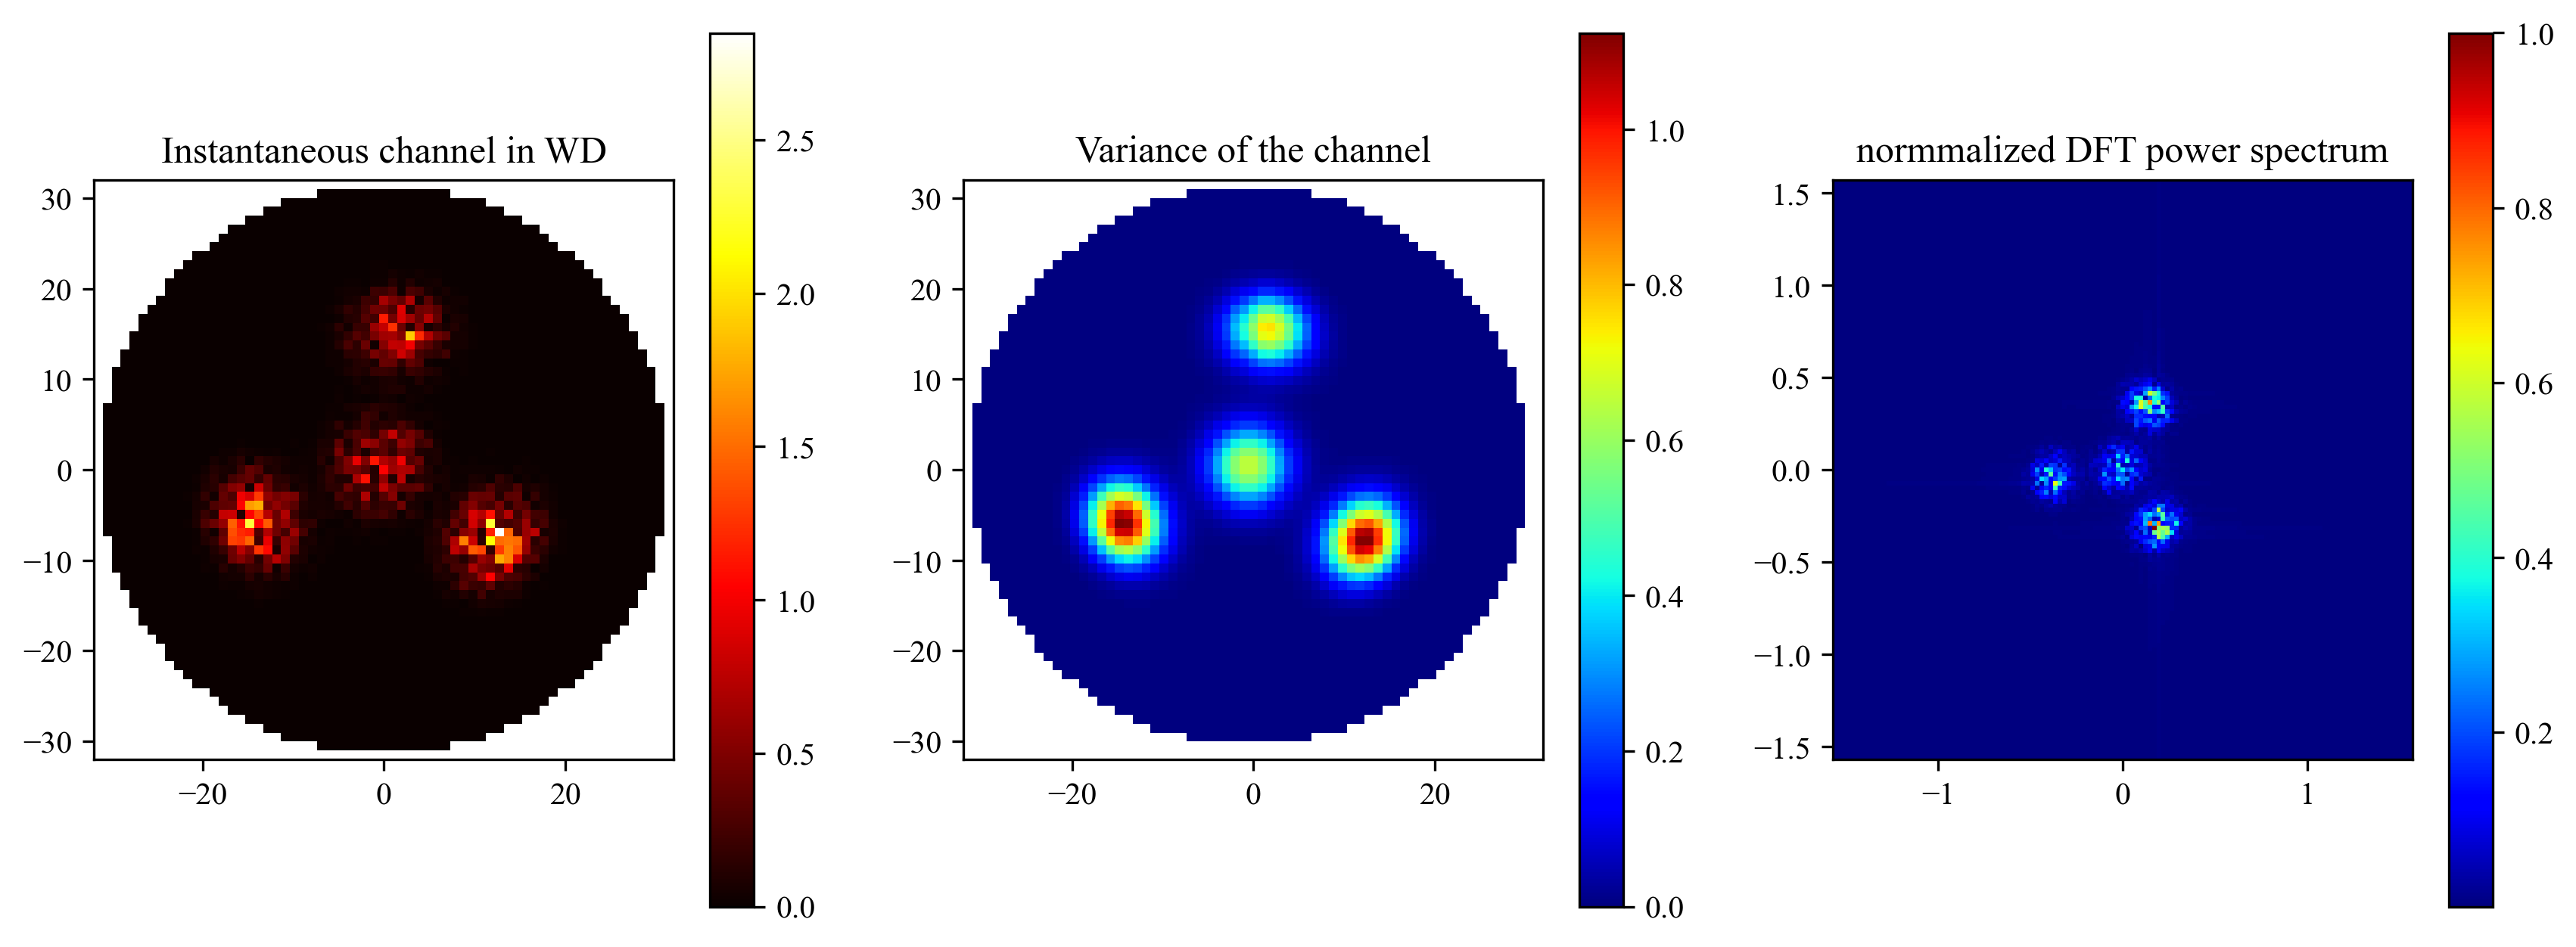

In [7]:
plt.figure(figsize=(14, 5))
# sub out of 3 in one row
plt.subplot(131)
visualize_wavenumber_domain_channel(vec_H_a)

plt.subplot(132)
visualize_wavenumber_variance(variance)

plt.subplot(133)
vec_H_DFT = DFT_power_spectrum(H_channel)

# print sparseness
print("sparseness = ", find_real_sparseness(vec_H_a))
print("sparseness = ", find_real_sparseness(vec_H_DFT))

#### Observation Model

$$
{\bf y} = {\bf C} {\bf \Psi} {\bf h}_a + {\bf n}
$$

In [8]:
# Measurement matrxi for compressed sensing, {N}_{RF} \times N
measurement_matrix = np.random.randn(N_RF, N) * 1 / np.sqrt(N)

y = np.dot(
    measurement_matrix,
    np.dot(
        Psi, vec_H_a
    )
)
Phi = np.dot(measurement_matrix, Psi)

#### Self-made OMP alg

In [9]:
from tool_box.OMP import OMP
# add noise
noise = np.random.randn(*y.shape) + 1j * np.random.randn(*y.shape)
noise = noise / np.linalg.norm(noise) * np.linalg.norm(y) / 10 ** (SNR / 20) 
y = y + noise

myOMP = OMP(
    A = np.array(Phi), 
    y = np.array(y), 
    vec_H_a = vec_H_a,
    sparseness = find_real_sparseness(vec_H_a), 
    norm_err_threshold = 1e-1)

### Show Progress bar

In [10]:
vec_H_a_recovered, vec_H_a_nonzero_idx, vec_H_a_err = myOMP.run()

100%|██████████| 415/415 [00:20<00:00, 20.05it/s] 


Text(0.5, 1.0, 'Recovered Channel')

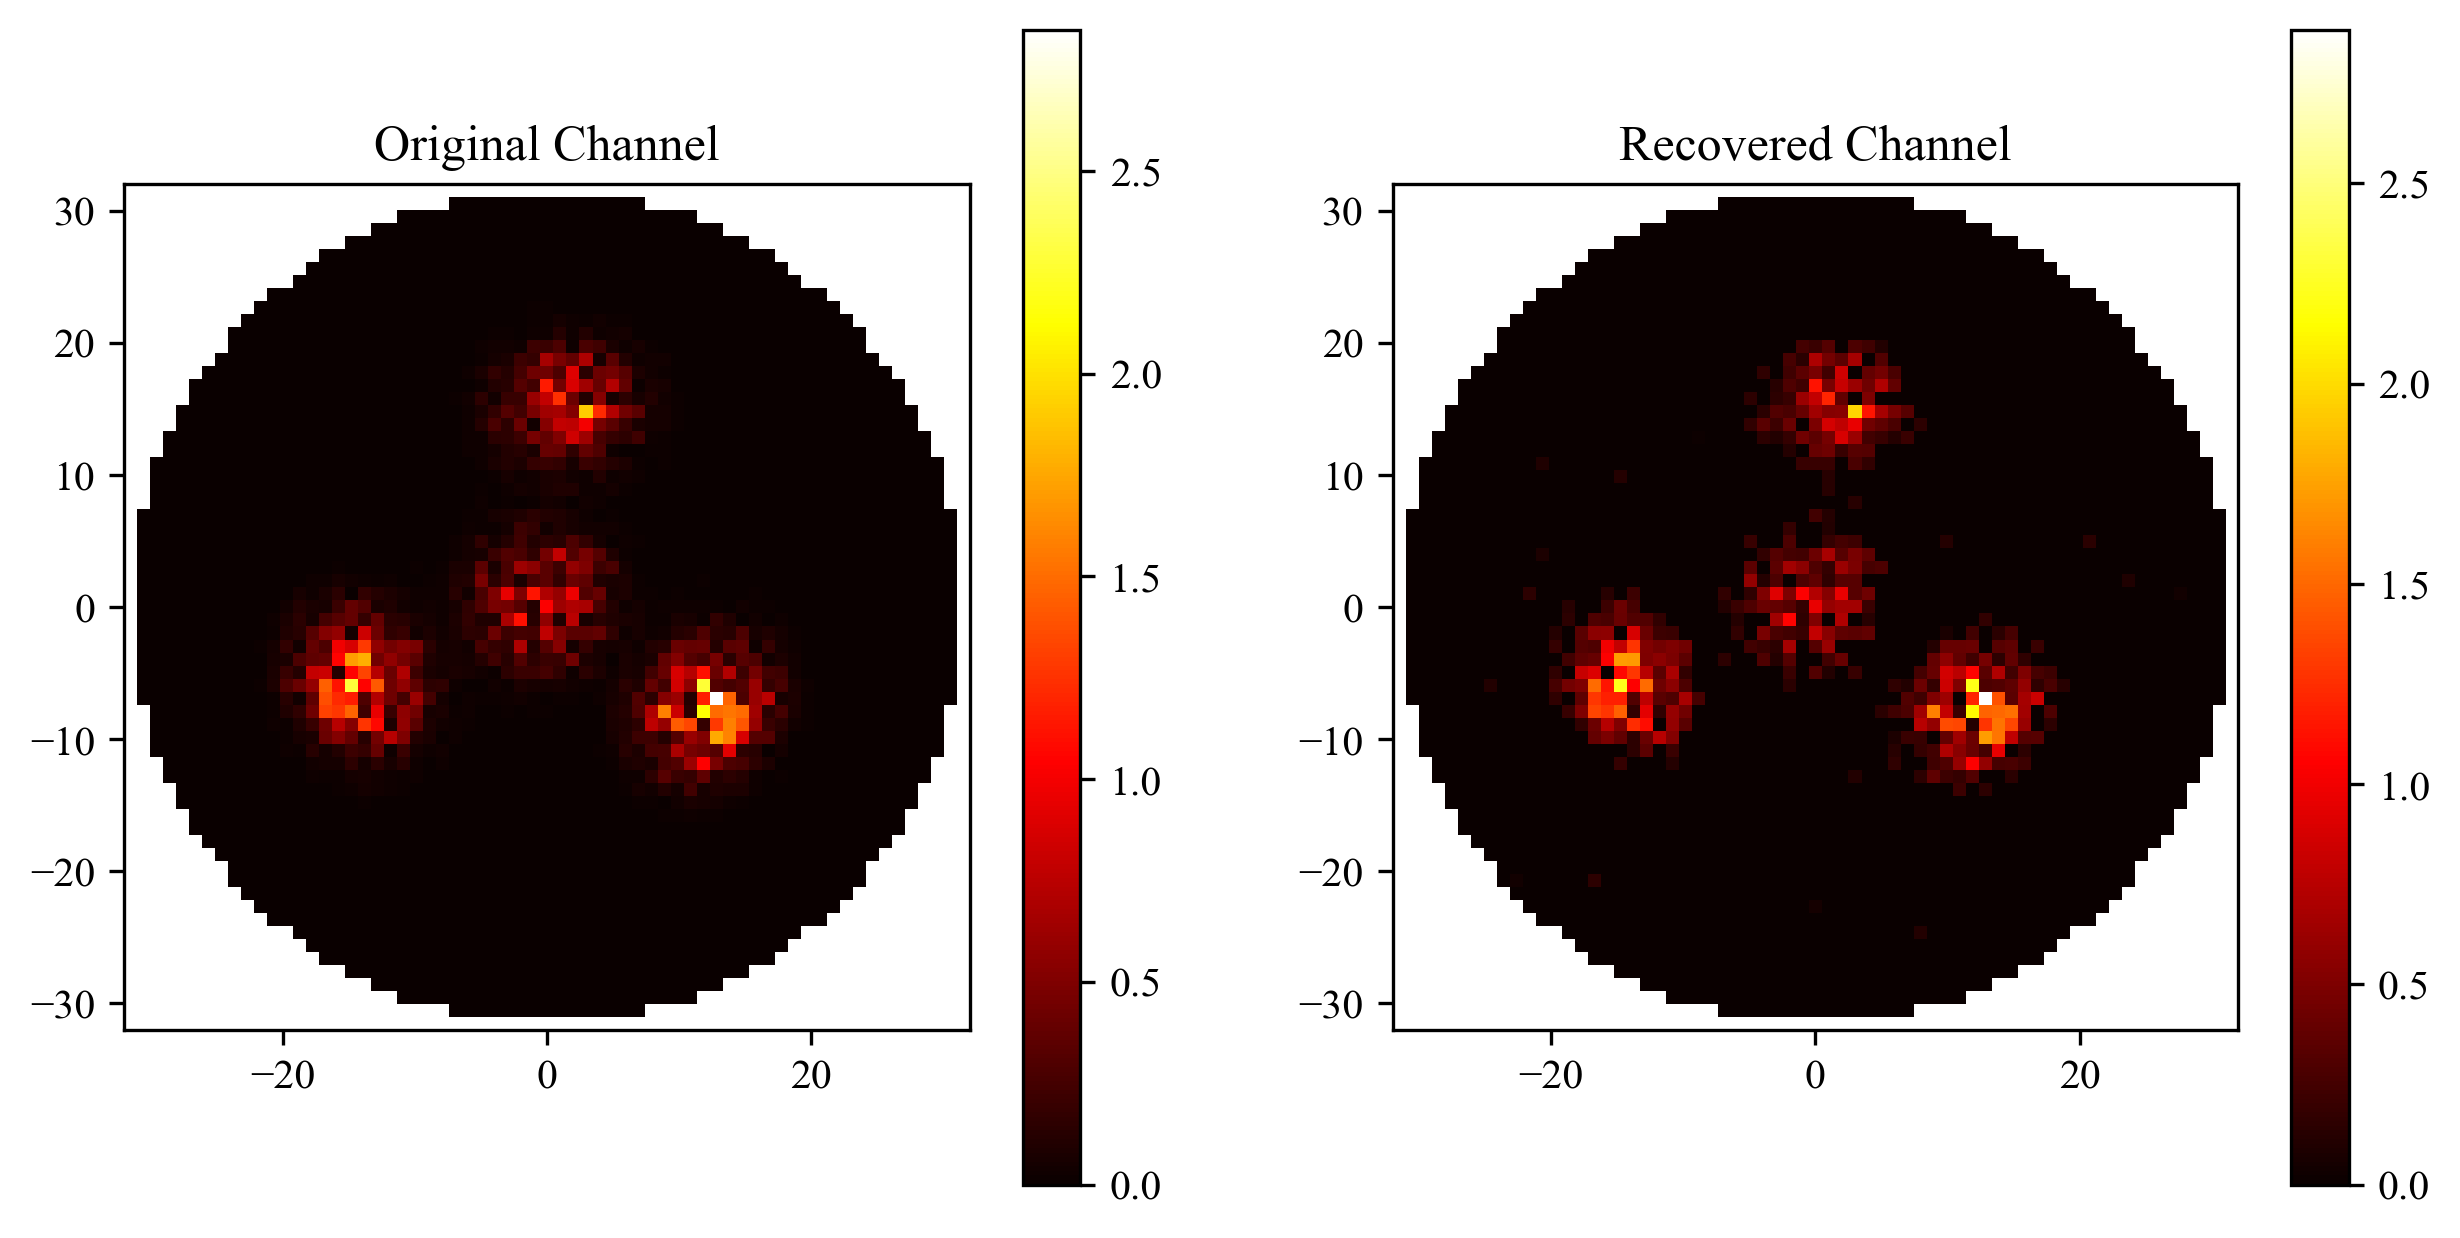

In [11]:
plt.figure(figsize=(10, 5))
# sub 1
plt.subplot(1, 2, 1)
visualize_wavenumber_domain_channel(vec_H_a)
# title
plt.title("Original Channel")

# sub 2
plt.subplot(1, 2, 2)
visualize_wavenumber_domain_channel(vec_H_a_recovered)
# title 
plt.title("Recovered Channel")

mini in log scale =  0.02247137144400068
mini in log scale =  0.022268219856183498
Converge NMSE =  0.022589434579695984
Converge NMSE_v2 =  0.02238206749458207


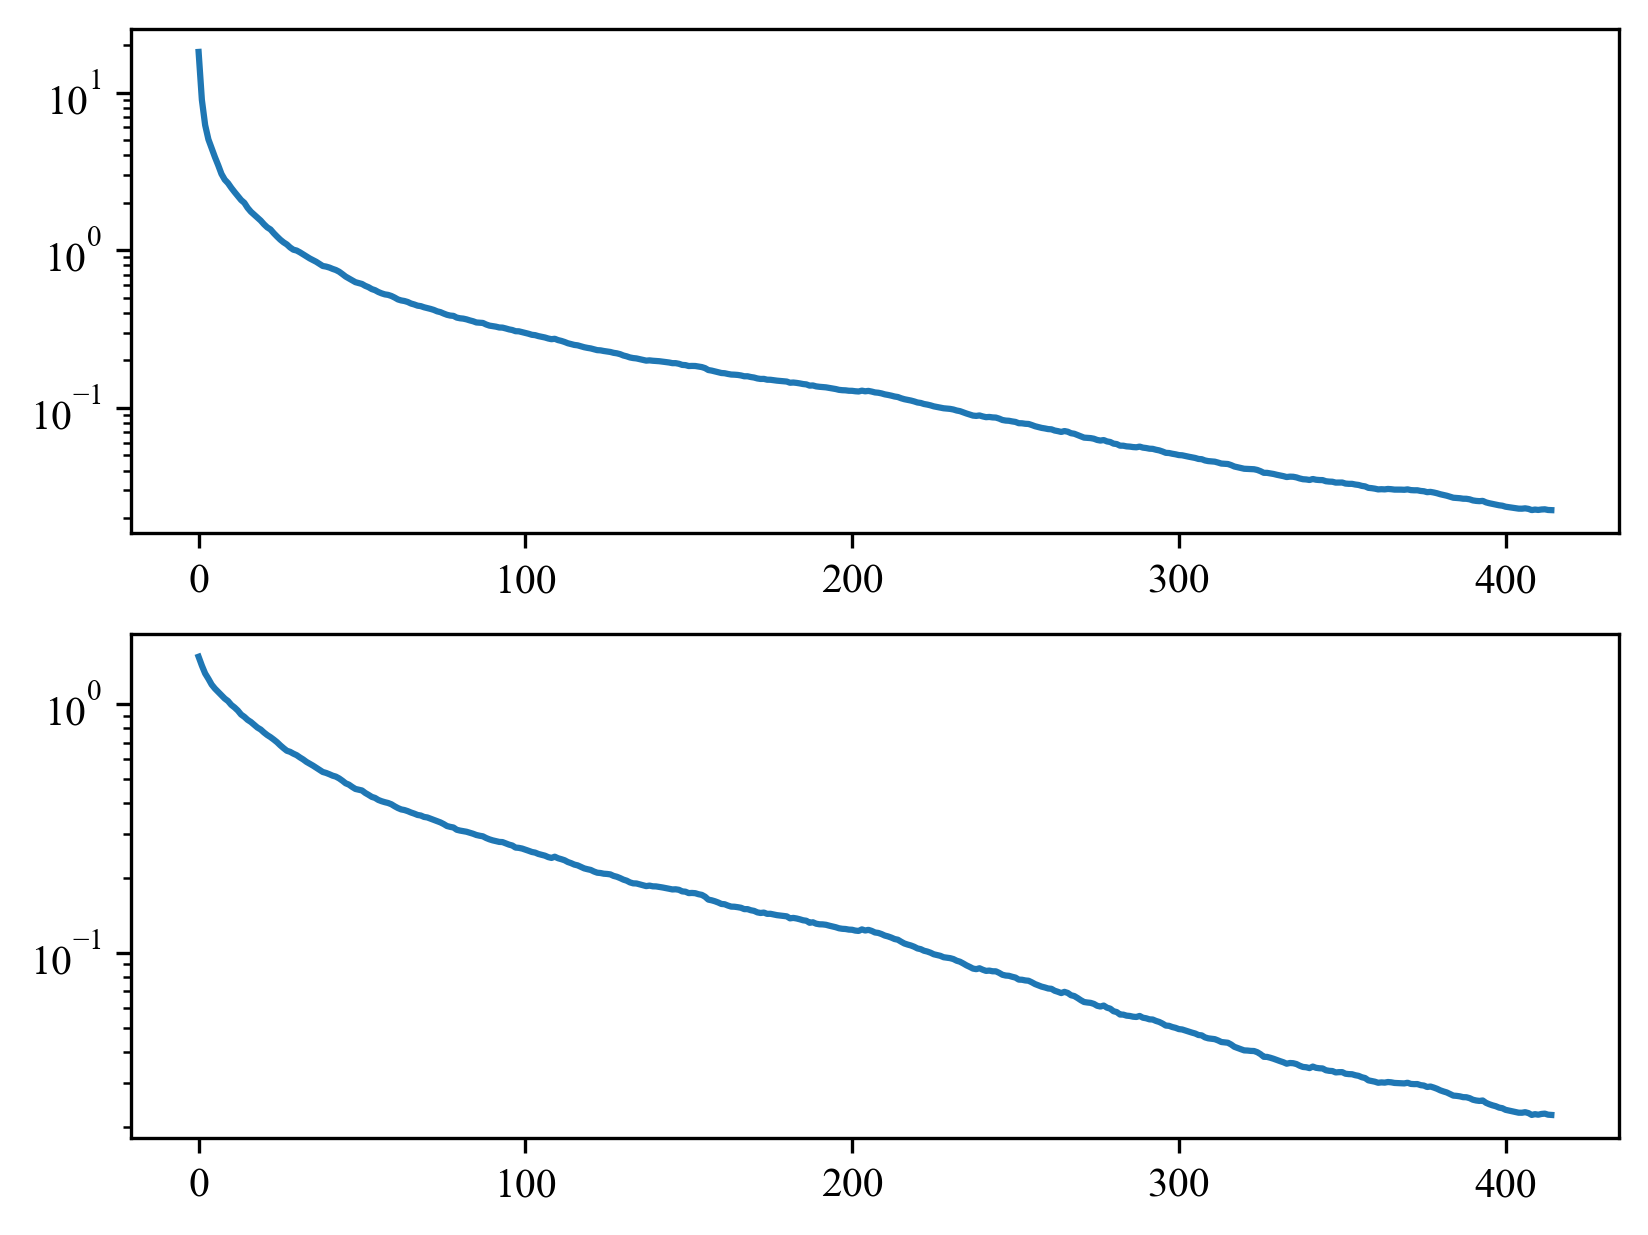

In [12]:
NMSE_list_v2 = myOMP.NMSE_list_v2
NMSE_list = myOMP.NMSE_list
plt.figure()
plt.subplot(211)
plt.plot(NMSE_list)
plt.yscale('log')

plt.subplot(212)
plt.plot(NMSE_list_v2)
plt.yscale('log')
# set log scale
# print mini 
print("mini in log scale = ", np.min(NMSE_list))
print("mini in log scale = ", np.min(NMSE_list_v2))


# print the mean of the last 5 NMSE
print("Converge NMSE = ", np.mean(NMSE_list[-5:]))
print("Converge NMSE_v2 = ", np.mean(NMSE_list_v2[-5:]))

#### Saving 

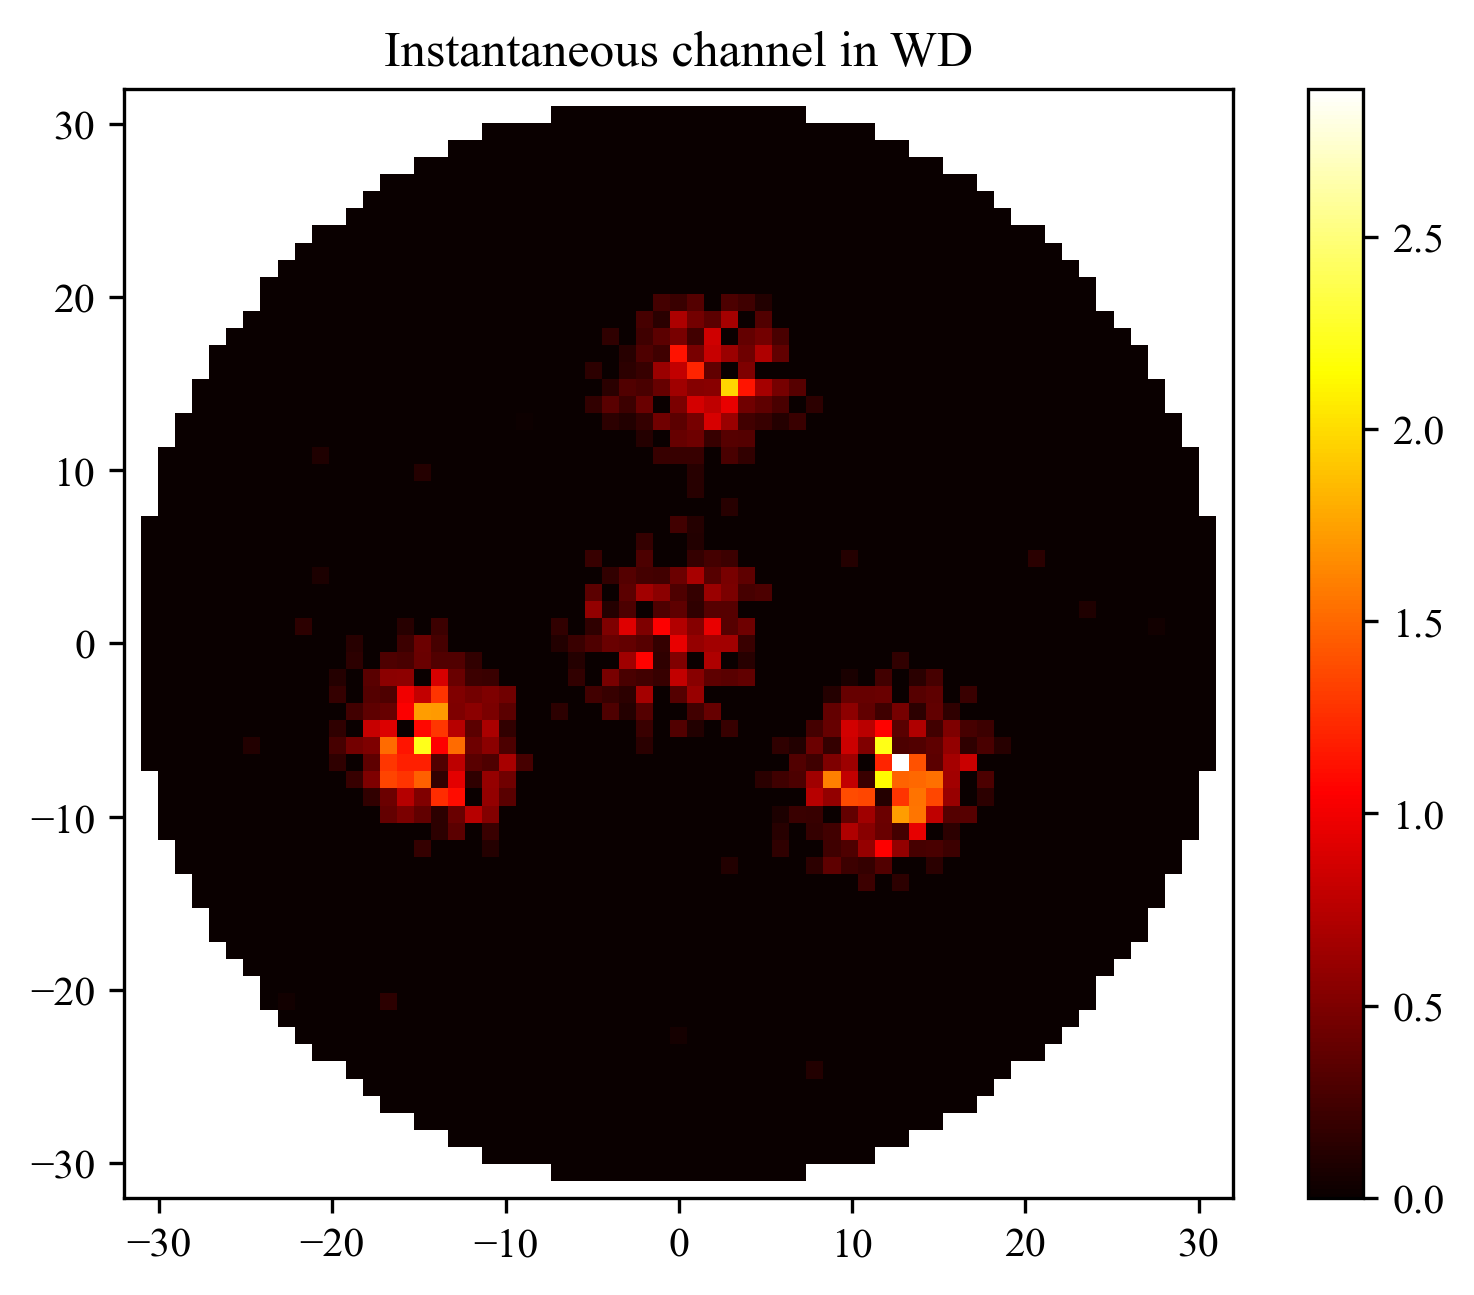

In [13]:
# Saving results
import os 
from scipy.io import savemat
# create folder if not exist
# folder = './data', with SNR and N_RF and spacing
spacing = int(lambda_c / delta)
folder = './data' + '/SNR_' + str(SNR) + '_Nx_' + str(N_x) + '_RF_' + str(N_RF) + '_spacing_' + str(spacing)
if not os.path.exists(folder):
    os.makedirs(folder)

# test_visual(path=folder + "/RecoveryCompare.png")

savemat(folder + '/alg_OMP_WND.mat', {
    'NMSE_list_v2' : NMSE_list_v2,
    'NMSE_list' : NMSE_list,
    'vec_H_a_recovered' : visualize_wavenumber_domain_channel(vec_H_a_recovered),
    'meta_data' : {
        # 'cluster_para' : cluster_para,
        'f_c' : f_c,
        'N_x' : N_x,
        'N_y' : N_y,
        'lambda_c' : lambda_c,
        'delta' : delta,
        'N' : N,
        'N_RF' : N_RF,
        'L_x' : L_x,
        'L_y' : L_y,
        # 'K' : K,
        'sparseness' : find_real_sparseness(vec_H_a),
        # 'sparse_power_threshold' : sparse_power_threshold,
        # 'eta' : eta,
        'xi' : xi,
        'l_x_abs_max' : l_x_abs_max,
        'l_y_abs_max' : l_y_abs_max,
        # 'M' : M,
        'SNR' : SNR,
        # 'iter_num' : iter_num
    },
}
)